In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from IPython import display

module://ipykernel.pylab.backend_inline


#  寶可夢自動編碼器 (tensorflow)

In [2]:
import os
os.environ['TRIDENT_BACKEND'] = 'tensorflow'
#!pip install tridentx --upgrade
import trident as T
from trident import *

trident 0.5.1
Using TensorFlow backend.
Image Data Format: channels_last.
Image Channel Order: rgb.


Tensorflow version:2.2.0-rc1.
use device:PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU').
executing_eagerly


Using pillow image backend.
Pillow version:6.2.1.


In [3]:
dataset=T.load_examples_data('pokemon')

archive file is already existing, donnot need download again.
extraction is finished, donnot need extract again.
C:/Users/Allan/.trident/datasets/examples_pokemon/pokemon
get pokemon images :1444


In [4]:
dataset.image_transform_funcs=[resize((130,130)),
                               random_crop(128,128),
                               normalize(127.5,127.5)]       

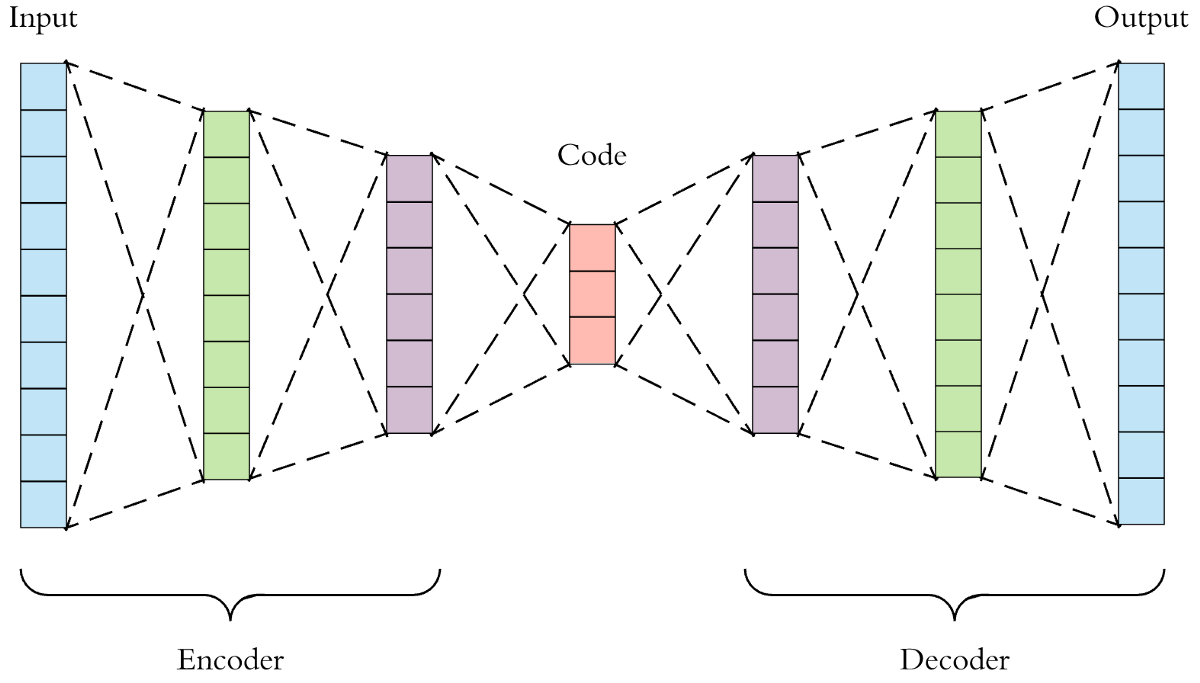

In [5]:
display.Image('../images/autoencoder.png',width=600)

In [6]:


encoder=Sequential(
    Conv2d_Block((5,5),32,strides=1,auto_pad=True,activation='leaky_relu',normalization='batch',use_bias=False, add_noise=True,noise_intensity=0.05),#(32,128,128)
    Conv2d_Block((3,3),64,strides=2,auto_pad=True,activation='leaky_relu',normalization='batch',use_bias=False),#(64,64,64)
    Conv2d_Block((3,3),64,strides=2,auto_pad=True,activation='leaky_relu',normalization='batch',use_bias=False),#(64,32,32)
    Conv2d_Block((3,3),128,strides=2,auto_pad=True,activation='leaky_relu',normalization='batch',use_bias=False,dropout_rate=0.5),#(128,16,16)
    Conv2d_Block((3,3),128,strides=2,auto_pad=True,activation='leaky_relu',normalization='batch',use_bias=False),#(128,8,8)
    Conv2d_Block((3,3),256,strides=2,auto_pad=True,activation='leaky_relu',normalization='batch',use_bias=False),#(256,4,4)
    Conv2d_Block((3,3),256,strides=1,auto_pad=True,activation='leaky_relu',normalization='batch',use_bias=False),#(256,4,4)
    Reshape((1,1,-1)), #(256*4*4)
    Conv2d((1,1),128,strides=1,auto_pad=True,activation='tanh',use_bias=False)
)




decoder=Sequential(
    Conv2d((1,1),128*32,strides=1,auto_pad=True,activation='tanh',use_bias=False), #(2048,1,1 )
    Reshape((8,8,64)), #(128,4,4))
    Conv2d_Block((3,3),128,strides=1,auto_pad=True,activation='leaky_relu',normalization='batch',use_bias=False) ,#((128,4,4))
    TransConv2d_Block((3,3),128,strides=2,auto_pad=True,activation='leaky_relu',normalization='batch',use_bias=False),#(128,8,8)
    TransConv2d_Block((3,3),64,strides=2,auto_pad=True,activation='leaky_relu',normalization='batch',use_bias=False),#(64,16,16)
    TransConv2d_Block((3,3),64,strides=2,auto_pad=True,activation='leaky_relu',normalization='batch',use_bias=False),#(64,32,32)
    TransConv2d_Block((3,3),64,strides=2,auto_pad=True,activation='leaky_relu',normalization='batch',use_bias=False),#(64,64,64)
    Conv2d_Block((3,3),128,strides=1,auto_pad=True,activation='leaky_relu',normalization='batch',use_bias=False),#(64,128,128)
    Conv2d((1,1),3,strides=1,auto_pad=True,activation='tanh',use_bias=False)
 )


In [7]:
autoencoder=Sequential(
    encoder,
    decoder
)

In [8]:
model=Model(input_shape=[128,128,3],output=autoencoder)\
    .with_optimizer(optimizer='Ranger',lr=2e-3, betas=(0.9,0.999))\
    .with_loss(MSELoss,loss_weight=1,name='l2 loss')\
    .with_metric(rmse,name='rmse')\
    .with_regularizer('l2')\
    .with_model_save_path('Models/pokemon_ae_tf.h5')\
    .with_learning_rate_scheduler(reduce_lr_on_plateau,monitor='rmse',mode='min',factor=0.5,patience=3,cooldown=2,threshold=5e-5,warmup=0)\


model.summary()

l2 loss signature:[('output', TensorShape([128, 128, 3])), ('target', TensorShape([128, 128, 3]))]
rmse signature:[('output', TensorShape([128, 128, 3])), ('target', TensorShape([128, 128, 3]))]
--------------------------------------------------------------------------------------------------------------------------------
              Layer (type)                   Output Shape            Weight           Bias    Param #     FLOPS #   
conv2d                                   [-1, 128, 128, 128]     [3, 3, 64, 128]               73728    2415902720.0
batch_norm                               [-1, 128, 128, 128]          [128]          [128]      256      6275072.0  
conv2d__block:0                          [-1, 128, 128, 32]                                      0          0.0     
conv2d__block:1                          [-1, 64, 64, 64]                                        0          0.0     
conv2d__block:2                          [-1, 8, 8, 128]                                   

In [9]:

plan=TrainingPlan()\
    .add_training_item(model)\
    .with_data_loader(dataset)\
    .repeat_epochs(500)\
    .within_minibatch_size(32)\
    .print_progress_scheduling(20,unit='batch')\
    .save_model_scheduling(10,unit='epoch')\
    .display_loss_metric_curve_scheduling(frequency=10,unit='epoch',imshow=True)\
    .display_tile_image_scheduling(5,'epoch','Results/','pokemon_ae_{0}.png',True,True,False,False,True)



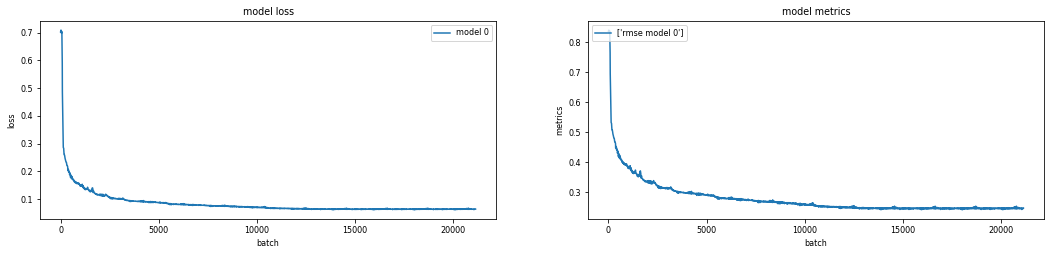

model 0      Step: 11s73ms  | Loss: 0.062   | rmse: 24.400%  | learning rate: 1.000e-08 | epoch: 460  ( 0/46 )
OrderedDict([('total_losses', 0.06206812337040901), ('l2 loss', 0.05670631304383278), ('l2_reg_Loss', 0.002500888193026185)])
model 0      Step: 27s176ms | Loss: 0.063   | rmse: 24.518%  | learning rate: 1.000e-08 | epoch: 460  ( 20/46 )
model 0      Step: 44s375ms | Loss: 0.064   | rmse: 24.778%  | learning rate: 1.000e-08 | epoch: 460  ( 40/46 )


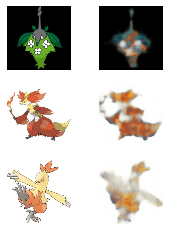

model 0      Step: 15s790ms | Loss: 0.062   | rmse: 24.449%  | learning rate: 1.000e-08 | epoch: 461  ( 0/46 )
OrderedDict([('total_losses', 0.0623181127011776), ('l2 loss', 0.06500938534736633), ('l2_reg_Loss', 0.002500888193026185)])
model 0      Step: 30s860ms | Loss: 0.062   | rmse: 24.435%  | learning rate: 1.000e-08 | epoch: 461  ( 20/46 )
model 0      Step: 23s839ms | Loss: 0.064   | rmse: 24.822%  | learning rate: 1.000e-08 | epoch: 461  ( 40/46 )
model 0      Step: 6s377ms  | Loss: 0.063   | rmse: 24.557%  | learning rate: 1.000e-08 | epoch: 462  ( 0/46 )
OrderedDict([('total_losses', 0.06284340471029282), ('l2 loss', 0.06174777075648308), ('l2_reg_Loss', 0.002500888193026185)])
model 0      Step: 28s971ms | Loss: 0.062   | rmse: 24.404%  | learning rate: 1.000e-08 | epoch: 462  ( 20/46 )
model 0      Step: 30s499ms | Loss: 0.064   | rmse: 24.806%  | learning rate: 1.000e-08 | epoch: 462  ( 40/46 )
model 0      Step: 7s379ms  | Loss: 0.063   | rmse: 24.592%  | learning rate: 1

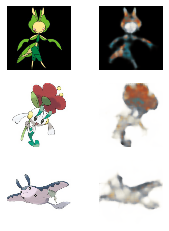

model 0      Step: 7s562ms  | Loss: 0.063   | rmse: 24.583%  | learning rate: 1.000e-08 | epoch: 466  ( 0/46 )
OrderedDict([('total_losses', 0.06295528262853622), ('l2 loss', 0.059743449091911316), ('l2_reg_Loss', 0.0025008886586874723)])
model 0      Step: 19s949ms | Loss: 0.063   | rmse: 24.498%  | learning rate: 1.000e-08 | epoch: 466  ( 20/46 )
model 0      Step: 18s709ms | Loss: 0.064   | rmse: 24.761%  | learning rate: 1.000e-08 | epoch: 466  ( 40/46 )
model 0      Step: 6s614ms  | Loss: 0.063   | rmse: 24.495%  | learning rate: 1.000e-08 | epoch: 467  ( 0/46 )
OrderedDict([('total_losses', 0.06250989437103271), ('l2 loss', 0.0619732141494751), ('l2_reg_Loss', 0.0025008886586874723)])
model 0      Step: 15s542ms | Loss: 0.063   | rmse: 24.500%  | learning rate: 1.000e-08 | epoch: 467  ( 20/46 )
model 0      Step: 16s305ms | Loss: 0.064   | rmse: 24.762%  | learning rate: 1.000e-08 | epoch: 467  ( 40/46 )
model 0      Step: 7s601ms  | Loss: 0.061   | rmse: 24.227%  | learning rate

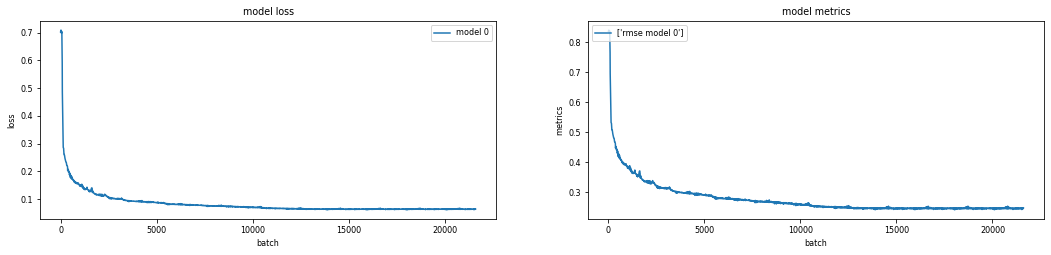

model 0      Step: 8s740ms  | Loss: 0.062   | rmse: 24.433%  | learning rate: 1.000e-08 | epoch: 470  ( 0/46 )
OrderedDict([('total_losses', 0.06224427744746208), ('l2 loss', 0.06067408248782158), ('l2_reg_Loss', 0.002500888891518116)])
model 0      Step: 25s150ms | Loss: 0.063   | rmse: 24.543%  | learning rate: 1.000e-08 | epoch: 470  ( 20/46 )
model 0      Step: 32s987ms | Loss: 0.064   | rmse: 24.707%  | learning rate: 1.000e-08 | epoch: 470  ( 40/46 )


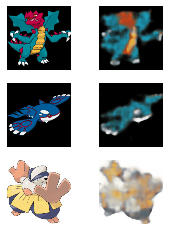

model 0      Step: 8s203ms  | Loss: 0.062   | rmse: 24.470%  | learning rate: 1.000e-08 | epoch: 471  ( 0/46 )
OrderedDict([('total_losses', 0.06242020055651665), ('l2 loss', 0.05784868076443672), ('l2_reg_Loss', 0.002500888891518116)])
model 0      Step: 28s843ms | Loss: 0.063   | rmse: 24.544%  | learning rate: 1.000e-08 | epoch: 471  ( 20/46 )
model 0      Step: 33s874ms | Loss: 0.064   | rmse: 24.705%  | learning rate: 1.000e-08 | epoch: 471  ( 40/46 )
model 0      Step: 9s30ms   | Loss: 0.062   | rmse: 24.481%  | learning rate: 1.000e-08 | epoch: 472  ( 0/46 )
OrderedDict([('total_losses', 0.062470871955156326), ('l2 loss', 0.060946766287088394), ('l2_reg_Loss', 0.002500888891518116)])
model 0      Step: 41s365ms | Loss: 0.063   | rmse: 24.586%  | learning rate: 1.000e-08 | epoch: 472  ( 20/46 )
model 0      Step: 32s681ms | Loss: 0.063   | rmse: 24.682%  | learning rate: 1.000e-08 | epoch: 472  ( 40/46 )
model 0      Step: 6s189ms  | Loss: 0.062   | rmse: 24.383%  | learning rate

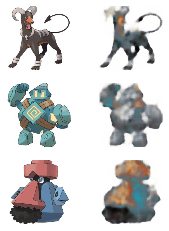

model 0      Step: 11s527ms | Loss: 0.063   | rmse: 24.625%  | learning rate: 1.000e-08 | epoch: 476  ( 0/46 )
OrderedDict([('total_losses', 0.06315962225198746), ('l2 loss', 0.06187150999903679), ('l2_reg_Loss', 0.0025008891243487597)])
model 0      Step: 23s468ms | Loss: 0.064   | rmse: 24.694%  | learning rate: 1.000e-08 | epoch: 476  ( 20/46 )
model 0      Step: 18s762ms | Loss: 0.063   | rmse: 24.507%  | learning rate: 1.000e-08 | epoch: 476  ( 40/46 )
model 0      Step: 5s480ms  | Loss: 0.063   | rmse: 24.689%  | learning rate: 1.000e-08 | epoch: 477  ( 0/46 )
OrderedDict([('total_losses', 0.0634724348783493), ('l2 loss', 0.06064007803797722), ('l2_reg_Loss', 0.0025008891243487597)])
model 0      Step: 17s731ms | Loss: 0.064   | rmse: 24.739%  | learning rate: 1.000e-08 | epoch: 477  ( 20/46 )
model 0      Step: 23s128ms | Loss: 0.062   | rmse: 24.445%  | learning rate: 1.000e-08 | epoch: 477  ( 40/46 )
model 0      Step: 5s717ms  | Loss: 0.063   | rmse: 24.557%  | learning rate:

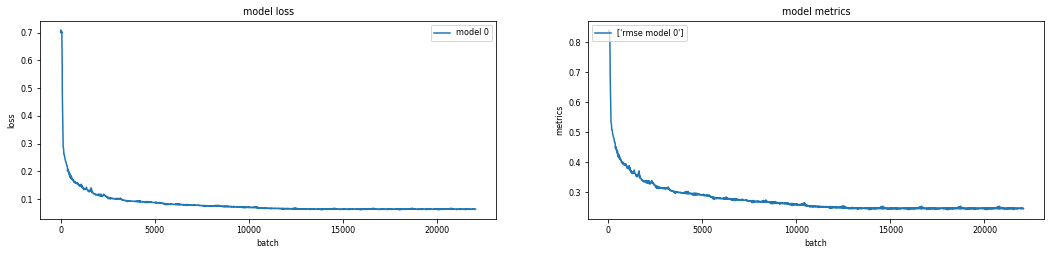

model 0      Step: 9s9ms    | Loss: 0.062   | rmse: 24.382%  | learning rate: 1.000e-08 | epoch: 480  ( 0/46 )
OrderedDict([('total_losses', 0.06196171045303345), ('l2 loss', 0.056609947234392166), ('l2_reg_Loss', 0.002500889590010047)])
model 0      Step: 32s454ms | Loss: 0.064   | rmse: 24.785%  | learning rate: 1.000e-08 | epoch: 480  ( 20/46 )
model 0      Step: 17s163ms | Loss: 0.062   | rmse: 24.477%  | learning rate: 1.000e-08 | epoch: 480  ( 40/46 )


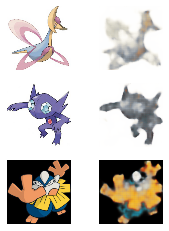

model 0      Step: 5s726ms  | Loss: 0.061   | rmse: 24.279%  | learning rate: 1.000e-08 | epoch: 481  ( 0/46 )
OrderedDict([('total_losses', 0.06147482618689537), ('l2 loss', 0.0555579774081707), ('l2_reg_Loss', 0.002500889590010047)])
model 0      Step: 31s220ms | Loss: 0.064   | rmse: 24.819%  | learning rate: 1.000e-08 | epoch: 481  ( 20/46 )
model 0      Step: 20s882ms | Loss: 0.063   | rmse: 24.505%  | learning rate: 1.000e-08 | epoch: 481  ( 40/46 )
model 0      Step: 8s300ms  | Loss: 0.061   | rmse: 24.186%  | learning rate: 1.000e-08 | epoch: 482  ( 0/46 )
OrderedDict([('total_losses', 0.06101328134536743), ('l2 loss', 0.05868880823254585), ('l2_reg_Loss', 0.002500889590010047)])
model 0      Step: 19s533ms | Loss: 0.064   | rmse: 24.824%  | learning rate: 1.000e-08 | epoch: 482  ( 20/46 )
model 0      Step: 17s931ms | Loss: 0.063   | rmse: 24.535%  | learning rate: 1.000e-08 | epoch: 482  ( 40/46 )
model 0      Step: 6s218ms  | Loss: 0.061   | rmse: 24.278%  | learning rate: 1

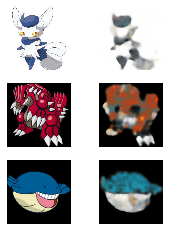

model 0      Step: 5s916ms  | Loss: 0.063   | rmse: 24.490%  | learning rate: 1.000e-08 | epoch: 486  ( 0/46 )
OrderedDict([('total_losses', 0.06250526010990143), ('l2 loss', 0.05953535437583923), ('l2_reg_Loss', 0.0025008898228406906)])
model 0      Step: 21s791ms | Loss: 0.064   | rmse: 24.778%  | learning rate: 1.000e-08 | epoch: 486  ( 20/46 )
model 0      Step: 21s606ms | Loss: 0.062   | rmse: 24.423%  | learning rate: 1.000e-08 | epoch: 486  ( 40/46 )
model 0      Step: 6s322ms  | Loss: 0.064   | rmse: 24.738%  | learning rate: 1.000e-08 | epoch: 487  ( 0/46 )
OrderedDict([('total_losses', 0.06370747834444046), ('l2 loss', 0.06301355361938477), ('l2_reg_Loss', 0.0025008898228406906)])
model 0      Step: 25s124ms | Loss: 0.064   | rmse: 24.763%  | learning rate: 1.000e-08 | epoch: 487  ( 20/46 )
model 0      Step: 31s744ms | Loss: 0.062   | rmse: 24.403%  | learning rate: 1.000e-08 | epoch: 487  ( 40/46 )
model 0      Step: 8s216ms  | Loss: 0.064   | rmse: 24.824%  | learning rate

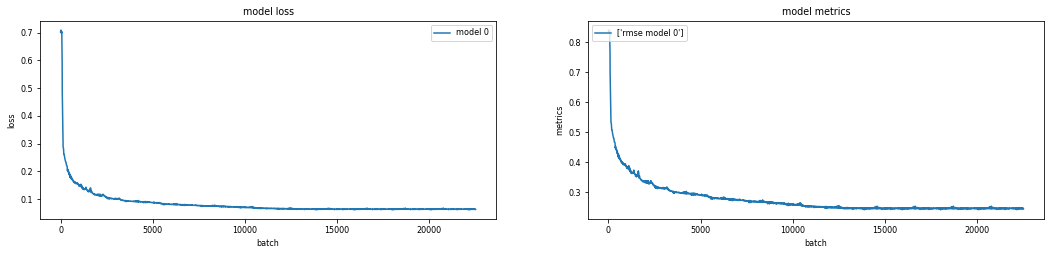

model 0      Step: 7s752ms  | Loss: 0.064   | rmse: 24.699%  | learning rate: 1.000e-08 | epoch: 490  ( 0/46 )
OrderedDict([('total_losses', 0.06351076811552048), ('l2 loss', 0.059568773955106735), ('l2_reg_Loss', 0.0025008898228406906)])
model 0      Step: 25s203ms | Loss: 0.064   | rmse: 24.715%  | learning rate: 1.000e-08 | epoch: 490  ( 20/46 )
model 0      Step: 22s930ms | Loss: 0.063   | rmse: 24.498%  | learning rate: 1.000e-08 | epoch: 490  ( 40/46 )


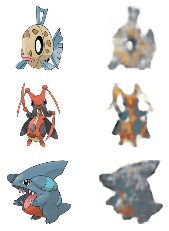

model 0      Step: 6s762ms  | Loss: 0.063   | rmse: 24.611%  | learning rate: 1.000e-08 | epoch: 491  ( 0/46 )
OrderedDict([('total_losses', 0.06307787448167801), ('l2 loss', 0.059164732694625854), ('l2_reg_Loss', 0.0025008900556713343)])
model 0      Step: 27s712ms | Loss: 0.064   | rmse: 24.720%  | learning rate: 1.000e-08 | epoch: 491  ( 20/46 )
model 0      Step: 32s660ms | Loss: 0.063   | rmse: 24.491%  | learning rate: 1.000e-08 | epoch: 491  ( 40/46 )
model 0      Step: 5s708ms  | Loss: 0.064   | rmse: 24.769%  | learning rate: 1.000e-08 | epoch: 492  ( 0/46 )
OrderedDict([('total_losses', 0.06386303901672363), ('l2 loss', 0.06457138061523438), ('l2_reg_Loss', 0.0025008900556713343)])
model 0      Step: 33s927ms | Loss: 0.063   | rmse: 24.678%  | learning rate: 1.000e-08 | epoch: 492  ( 20/46 )
model 0      Step: 24s681ms | Loss: 0.063   | rmse: 24.504%  | learning rate: 1.000e-08 | epoch: 492  ( 40/46 )
model 0      Step: 6s860ms  | Loss: 0.064   | rmse: 24.828%  | learning rat

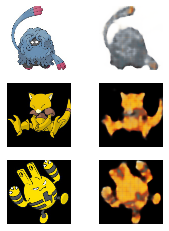

model 0      Step: 6s750ms  | Loss: 0.066   | rmse: 25.153%  | learning rate: 1.000e-08 | epoch: 496  ( 0/46 )
OrderedDict([('total_losses', 0.06579945236444473), ('l2 loss', 0.05993151664733887), ('l2_reg_Loss', 0.002500890288501978)])
model 0      Step: 27s324ms | Loss: 0.063   | rmse: 24.490%  | learning rate: 1.000e-08 | epoch: 496  ( 20/46 )
model 0      Step: 21s351ms | Loss: 0.063   | rmse: 24.546%  | learning rate: 1.000e-08 | epoch: 496  ( 40/46 )
model 0      Step: 6s324ms  | Loss: 0.067   | rmse: 25.335%  | learning rate: 1.000e-08 | epoch: 497  ( 0/46 )
OrderedDict([('total_losses', 0.06670638173818588), ('l2 loss', 0.0654340609908104), ('l2_reg_Loss', 0.0025008905213326216)])
model 0      Step: 25s224ms | Loss: 0.062   | rmse: 24.445%  | learning rate: 1.000e-08 | epoch: 497  ( 20/46 )
model 0      Step: 22s334ms | Loss: 0.063   | rmse: 24.581%  | learning rate: 1.000e-08 | epoch: 497  ( 40/46 )
model 0      Step: 5s727ms  | Loss: 0.065   | rmse: 24.930%  | learning rate: 

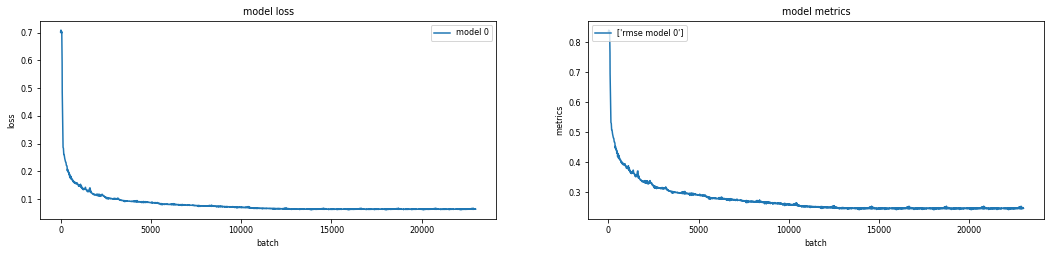

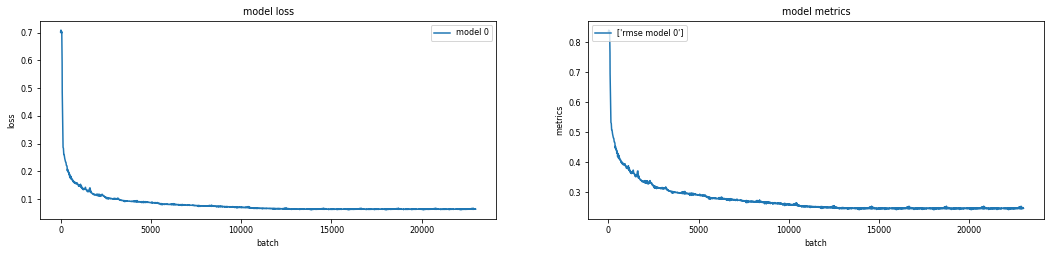

In [10]:
plan.start_now()

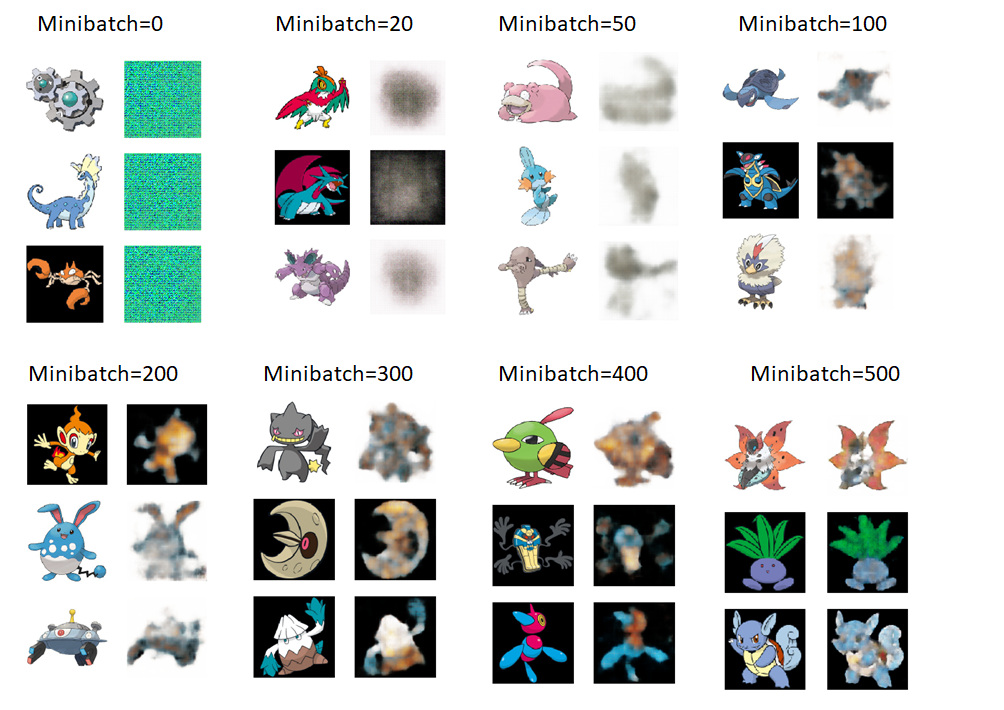

In [11]:
display.Image('../images/pokemon_training.png',width=800)

## 表徵學習 

In [12]:
features=[]


#dataset.data['train]
for img_data in dataset.get_all_data(get_image_mode = GetImageMode.processed):
    input=to_tensor(np.expand_dims(img_data,0))
    encoder_output = np.squeeze(to_numpy(autoencoder[0](input)))
    features.append(encoder_output)


features=np.asarray(features)
print(features.shape)
   

(1444, 128)


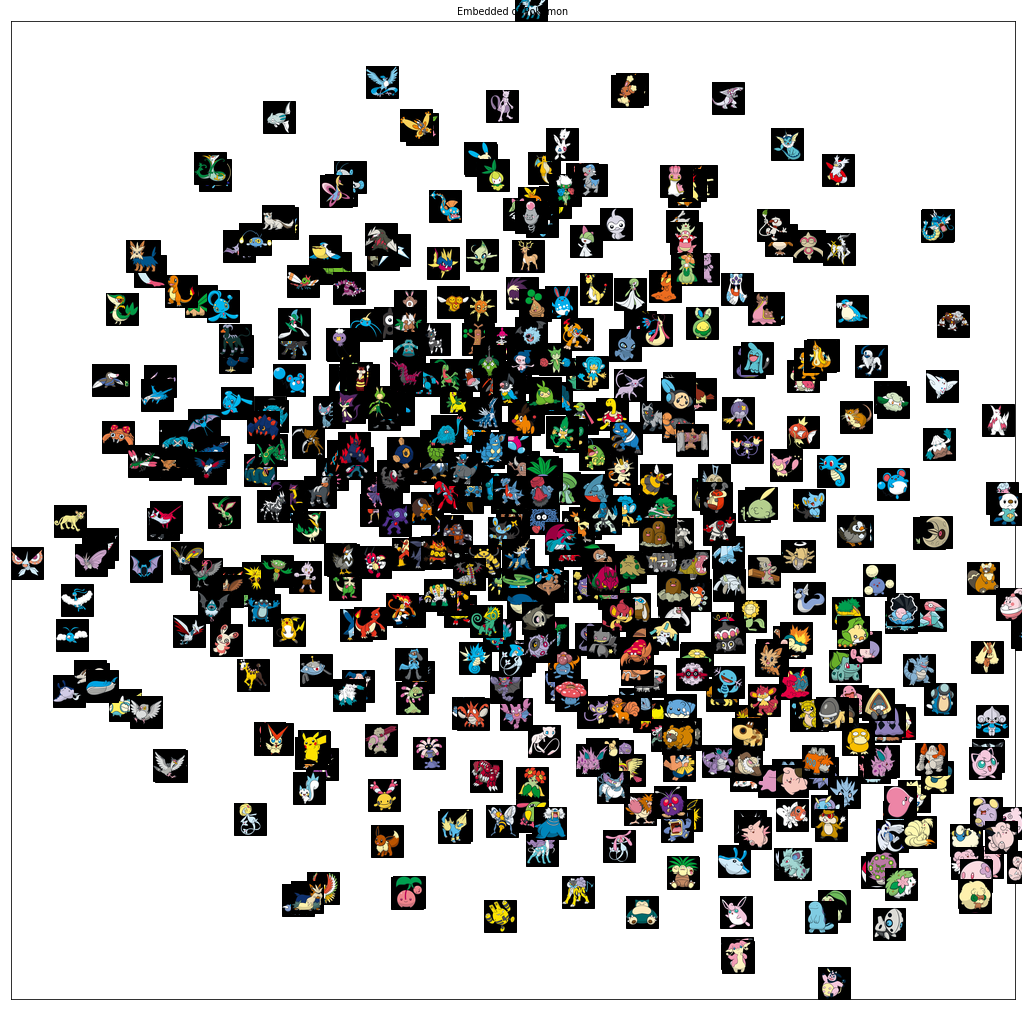

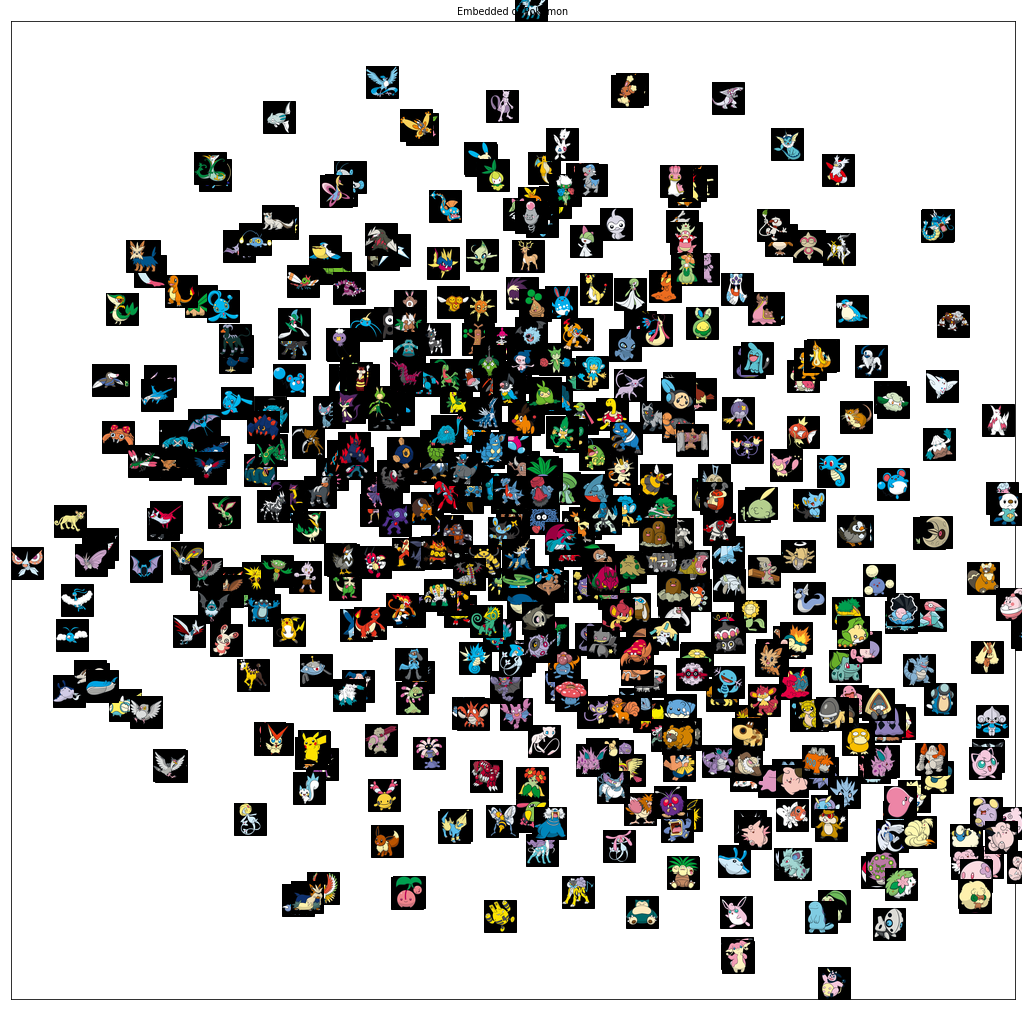

In [13]:
from matplotlib import offsetbox
from sklearn import manifold
import PIL
from PIL import Image as Image

def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    fig =plt.figure(figsize=(18,18))
    ax = plt.subplot(111)
    imgdata=dataset.get_all_data(get_image_mode = GetImageMode.expect)
    if hasattr(offsetbox, 'AnnotationBbox'):
        # 需要matplotlib 版本> 1.0才支援顯示圖片功能
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            
            shown_images = np.r_[shown_images, [X[i]]]
            #將向量轉圖片，且將圖片縮小至32*32
            img=array2image(imgdata[i]) #array2image是 trident 內的函數
            img = img.resize((32, 32),Image.ANTIALIAS)
            imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(img),X[i],pad=0, box_alignment=(0, 0))
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)
    display.display(fig)

#利用 t-SNE  降維
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)#利用t-sne將128特徵向量降維至2
X_tsne = tsne.fit_transform(features[:500,:])#為了避免圖片太密我只用了前500來處理

plot_embedding(X_tsne, "Embedded of Pokemon")#繪製圖像散布圖

## 寶可夢的相似性搜索 

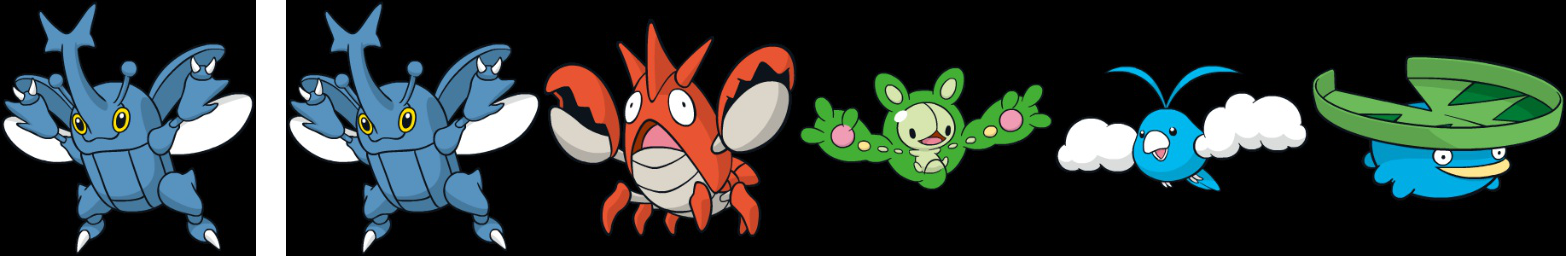

In [14]:
imgdata=np.array(dataset.get_all_data(get_image_mode = GetImageMode.raw))

def find_similar_pokemon(idx):
    similarity_list=[]
    result=to_numpy(element_cosine_distance(features[idx:idx+1,:],features))[0]  #element_cosine_distance逐成員計算Cosine距離
    
    top5=np.argsort(result)[-5:][::-1]  #找出前 5個Cosine距離最高者(Cosine距離是越高越像)

    similarity_list=[imgdata[idx]] #放入原圖
    similarity_list.append(np.ones_like(similarity_list[0])[:,:30,:]*255) # 加入白色分隔線
    similarity_list.extend(imgdata[top5]) #放入前 5名圖 

    merge_img=np.concatenate(similarity_list,axis=1) #沿著寬(axis=1)疊合
    display.display(array2image(merge_img)) #顯示結果



idx=128 #抽取一隻寶可夢
find_similar_pokemon(idx)

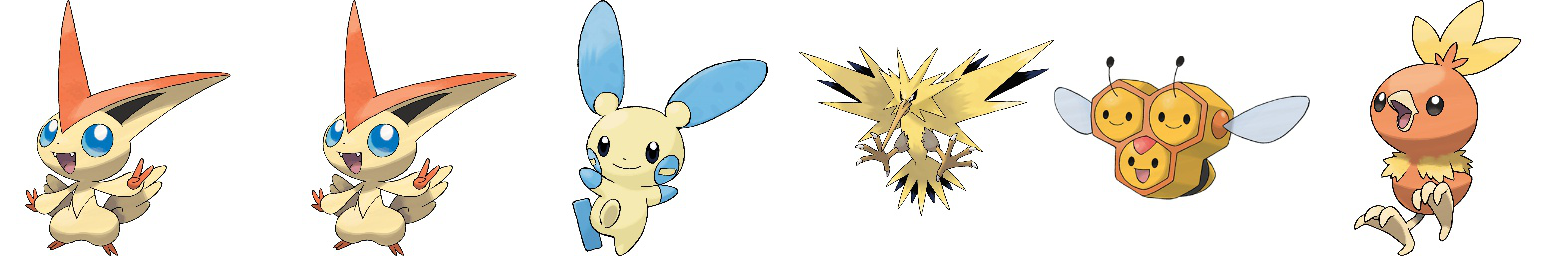

In [15]:
import random
find_similar_pokemon(random.choice(range(1444)))